# Importing Required Libraries for Data Preparation 

In [362]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Loading dataset and Examining Structure

In [363]:
df = pd.read_csv('data/gritdata.csv', delimiter = '\t')
df.head()
# changed delimiter to tab

,country,surveyelapse,GS1,GS2,GS3,GS4,GS5,GS6,GS7,GS8,...,O7,O8,O9,O10,operatingsystem,browser,screenw,screenh,introelapse,testelapse
0,RO,174,1,1,3,3,3,2,3,1,...,5,4,5,4,Windows,Chrome,1366,768,69590,307
1,US,120,2,2,3,3,2,1,3,3,...,4,3,4,5,Macintosh,Chrome,1280,800,33657,134
2,US,99,3,3,3,3,4,3,4,4,...,5,5,4,4,Windows,Firefox,1920,1080,95550,138
3,KE,5098,1,3,4,2,4,1,5,4,...,4,2,5,4,Windows,Chrome,1600,900,4,4440
4,JP,340,1,2,3,3,2,2,2,4,...,4,1,3,2,Windows,Firefox,1920,1080,3,337


In [364]:
df.shape
# (row, col)

(4270, 98)

In [365]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4270 entries, 0 to 4269
Data columns (total 98 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   country          4226 non-null   object
 1   surveyelapse     4270 non-null   int64 
 2   GS1              4270 non-null   int64 
 3   GS2              4270 non-null   int64 
 4   GS3              4270 non-null   int64 
 5   GS4              4270 non-null   int64 
 6   GS5              4270 non-null   int64 
 7   GS6              4270 non-null   int64 
 8   GS7              4270 non-null   int64 
 9   GS8              4270 non-null   int64 
 10  GS9              4270 non-null   int64 
 11  GS10             4270 non-null   int64 
 12  GS11             4270 non-null   int64 
 13  GS12             4270 non-null   int64 
 14  VCL1             4270 non-null   int64 
 15  VCL2             4270 non-null   int64 
 16  VCL3             4270 non-null   int64 
 17  VCL4             4270 non-null   

## Validity Check + Filtering

In [366]:
df = df[~((df["VCL6"]==1) | (df["VCL9"]==1) | (df["VCL12"]==1))]
# filtering out rows that are true (value == 1) in cols: VCL6, VCL9, VCL12

The validity check has been performed and the VCL columns are no longer required. I will remove them VCL6, VCL9, VCL12 but keep the rest just in case good vocabulary is an indicator of grit.

In [367]:
df = df.drop(columns = ["VCL6", "VCL9", "VCL12"])

### Filtering Survey Timing Data
Removing rows with unreasonable survey completion times:
- testelapse: 75-2000 seconds (too fast indicates careless responding, too slow indicates interruptions)
- introelapse: 0-800 seconds 
- surveyelapse: 72-2000 seconds

In [368]:
# Check how many rows fall outside acceptable timing ranges
print("Rows outside bounds:")
print(f"75 < testelapse < 2000: {((df['testelapse'] < 75) | (df['testelapse'] > 2000)).sum()}")
print(f"0 < introelapse < 800: {((df['introelapse'] < 0) | (df['introelapse'] > 800)).sum()}")
print(f"72 < surveyelapse < 2000: {((df['surveyelapse'] < 72) | (df['surveyelapse'] > 2000)).sum()}")
print(f"\nCurrent shape: {df.shape}")

Rows outside bounds:
75 < testelapse < 2000: 42
0 < introelapse < 800: 114
72 < surveyelapse < 2000: 16

Current shape: (3162, 95)


In [369]:
# Filter rows based on timing bounds
df = df[(df['testelapse'] >= 75) & (df['testelapse'] <= 2000) &
        (df['introelapse'] >= 0) & (df['introelapse'] <= 800) &
        (df['surveyelapse'] >= 72) & (df['surveyelapse'] <= 2000)]

In [370]:
# Verify filtering results
print(f"New shape after timing filter: {df.shape}")
print(f"\nUpdated timing statistics:")
print(df[["introelapse", "testelapse", "surveyelapse"]].describe())

New shape after timing filter: (3003, 95)

Updated timing statistics:
       introelapse   testelapse  surveyelapse
count  3003.000000  3003.000000   3003.000000
mean     38.064269   267.752248    232.262071
std      89.487635   173.386255    147.288365
min       1.000000    77.000000     72.000000
25%       5.000000   170.000000    148.000000
50%      10.000000   221.000000    194.000000
75%      28.000000   299.500000    262.000000
max     784.000000  1819.000000   1991.000000


In [371]:
df.duplicated().sum()

np.int64(0)

There are no duplicates in our data.

In [372]:
df.isna().sum()

country         31
surveyelapse     0
GS1              0
GS2              0
GS3              0
                ..
browser          0
screenw          0
screenh          0
introelapse      0
testelapse       0
Length: 95, dtype: int64

44 rows in the data have null values in the column "country". We will fill these null values with a placeholder value, "Unknown" so we can retain other information.

In [373]:
df['country'] = df['country'].fillna("Unknown")

In [374]:
df.isna().sum().sum()
# checking if there are any remaining null values 

np.int64(0)

In [375]:
# this demographics dataframe DOES NOT include familysize and age since its information 
# was collected differently by the user
demographics = ["education", "urban", "gender", "engnat", "hand", "religion", "orientation", 
"race", "voted", "married"]
demographics_df = df[demographics]
demographicZeroCount = (demographics_df == 0).sum()
print(demographicZeroCount)

education      23
urban          28
gender          3
engnat         16
hand           10
religion       43
orientation    89
race           21
voted          25
married        16
dtype: int64


A value marked 0 will be considered 'Unknown'.

<Axes: xlabel='age'>

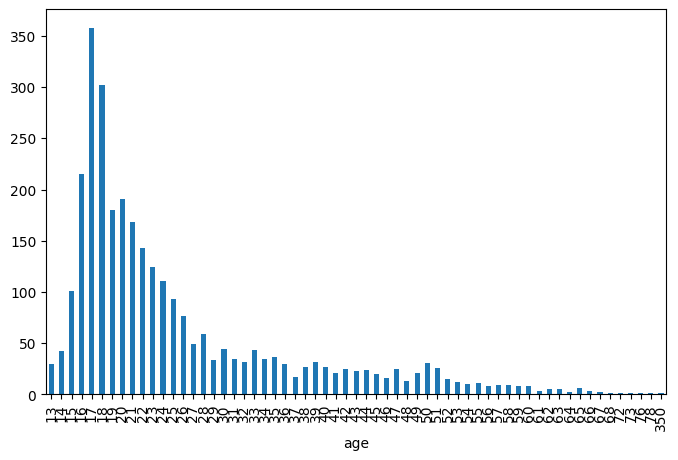

In [376]:
df['age'].value_counts().sort_index().plot(kind='bar', figsize=(8,5))

Here with our age column, we find two outliers, users who inserted their ages as 228 and 350. We will remove those rows.

In [377]:
df = df[~((df["age"]==228) | (df["age"]==350))]

<Axes: xlabel='familysize'>

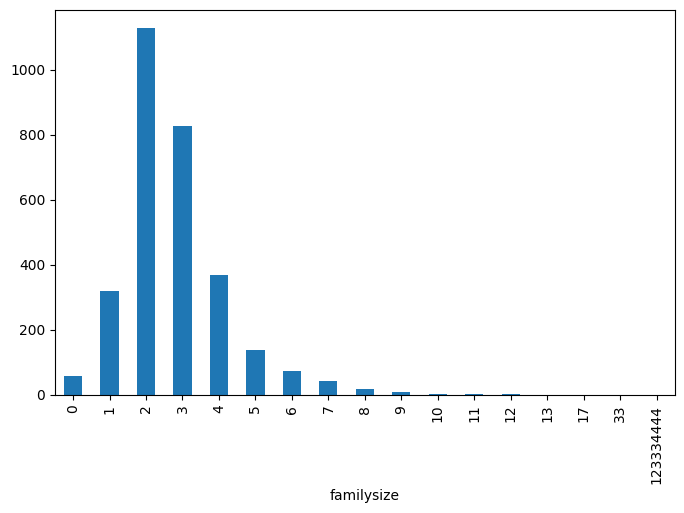

In [378]:
df['familysize'].value_counts().sort_index().plot(kind='bar', figsize=(8,5))

Here with our familysize column, we find a couple of outliers. Like the age column, we will remove those outlier rows.

In [379]:
df = df[~((df["familysize"]==0) | (df["familysize"]==123334444) | (df["familysize"]==33))]

In [380]:
# getting the columns of gritScore cols (GS1-GS12)
gritColumns = df.iloc[:,2:14].columns
print(gritColumns)

Index(['GS1', 'GS2', 'GS3', 'GS4', 'GS5', 'GS6', 'GS7', 'GS8', 'GS9', 'GS10',
       'GS11', 'GS12'],
      dtype='object')


In [381]:
# summing up the count of all missing data from Grit Scores
GritScoreZeroCount = (df[gritColumns] == 0).sum()
print(GritScoreZeroCount)

GS1      7
GS2      7
GS3      7
GS4     22
GS5      7
GS6      9
GS7      9
GS8      5
GS9      5
GS10     9
GS11     8
GS12    16
dtype: int64


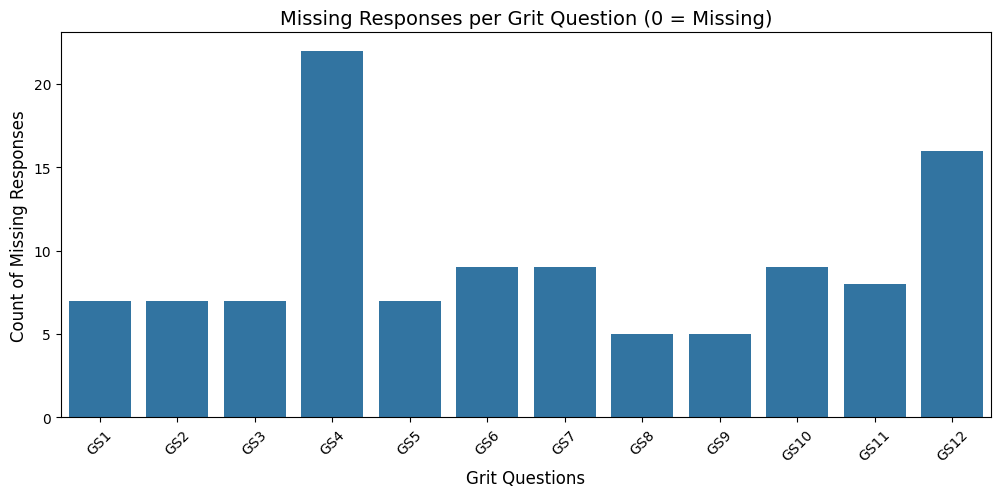

In [382]:
plt.figure(figsize=(12,5))
sns.barplot(x=GritScoreZeroCount.index, y=GritScoreZeroCount.values)
plt.title("Missing Responses per Grit Question (0 = Missing)", fontsize=14)
plt.xlabel("Grit Questions", fontsize=12)
plt.ylabel("Count of Missing Responses", fontsize=12)
plt.xticks(rotation=45)
plt.show()


Thesee are the amount of missing grit scores

In [383]:
# getting the columns of the Big 5 Personality Test 
bigPersonalities = [col for col in df.columns if col.startswith(("E", "N", "A", "C", "O"))]
print(bigPersonalities)
#columns=[col for col in df.columns if col.startswith("VCL")]

['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'O1', 'O2', 'O3', 'O4', 'O5', 'O6', 'O7', 'O8', 'O9', 'O10']


In [384]:
# summing up the count of all missing data from Big 5 Personality Test
bigPersonalitiesZeroCount = (df[bigPersonalities] == 0).sum()
print(bigPersonalitiesZeroCount)

E1      6
E2      7
E3      7
E4     10
E5     14
E6      4
E7     16
E8      3
E9      5
E10     3
N1      6
N2      9
N3      6
N4     10
N5      5
N6     11
N7      9
N8      8
N9      5
N10     9
A1      9
A2      7
A3      7
A4     10
A5      8
A6     11
A7      3
A8      5
A9      3
A10    11
C1      8
C2      8
C3      4
C4      9
C5      9
C6      9
C7      8
C8     11
C9      7
C10    12
O1      4
O2     13
O3     10
O4     11
O5      8
O6     13
O7      9
O8      8
O9      8
O10    11
dtype: int64


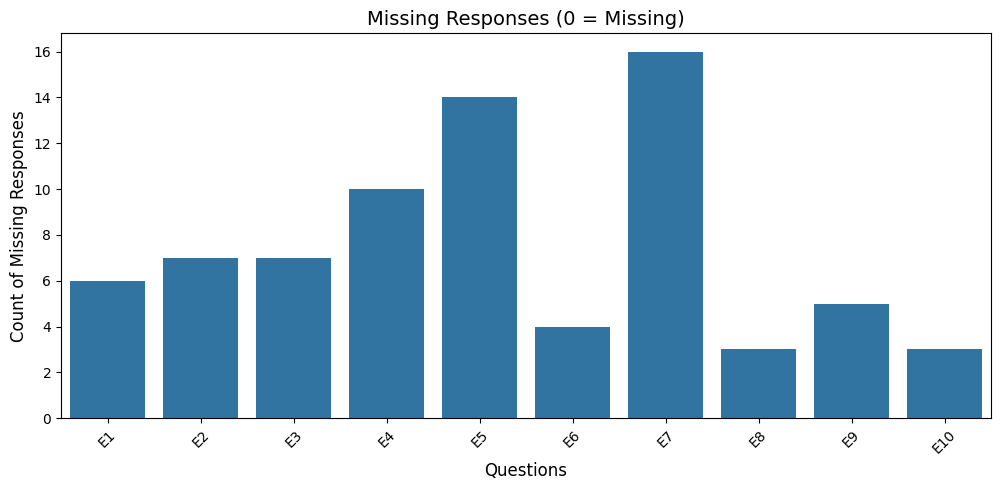

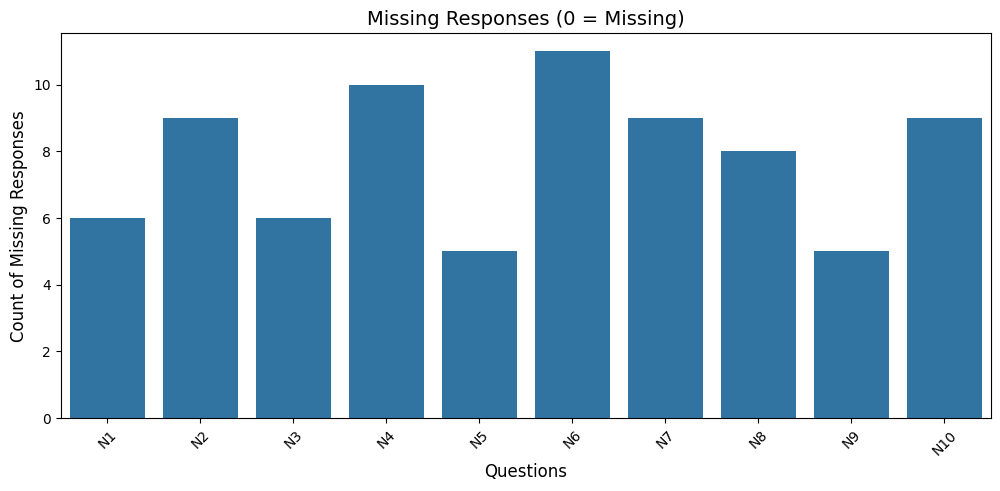

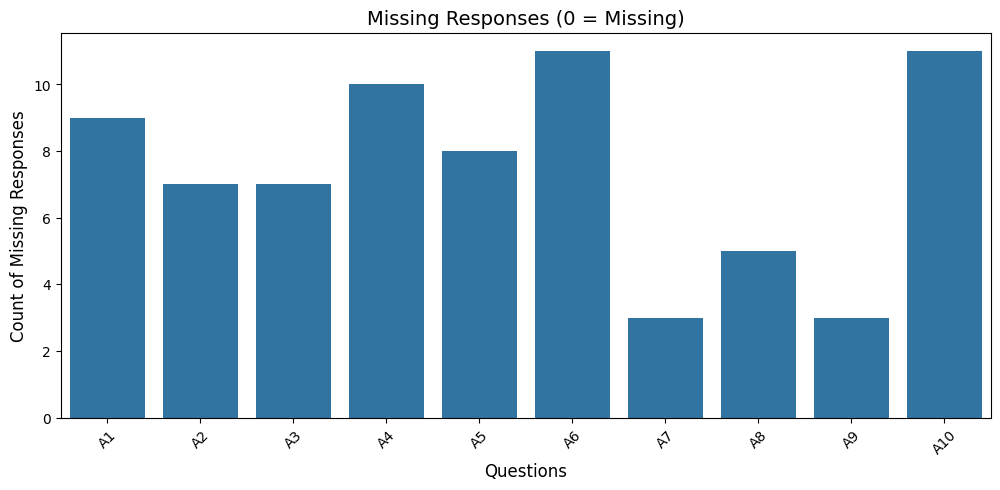

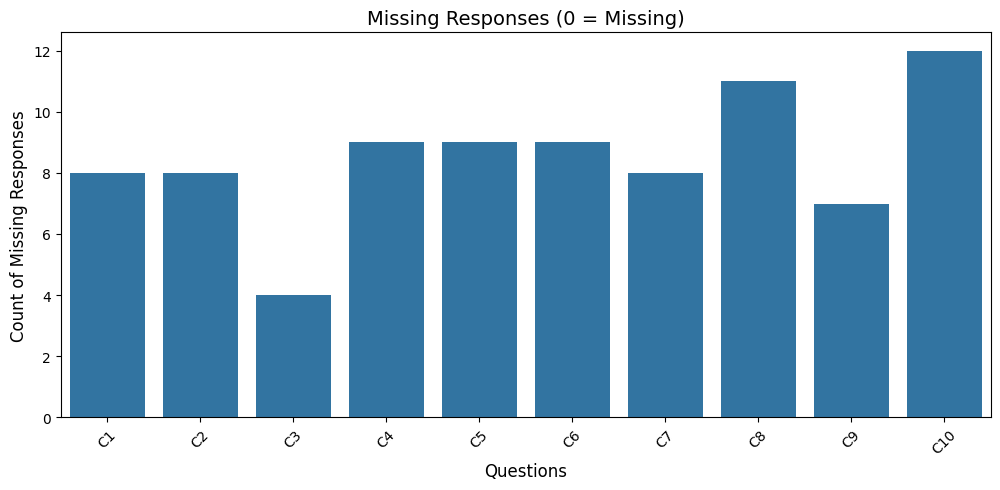

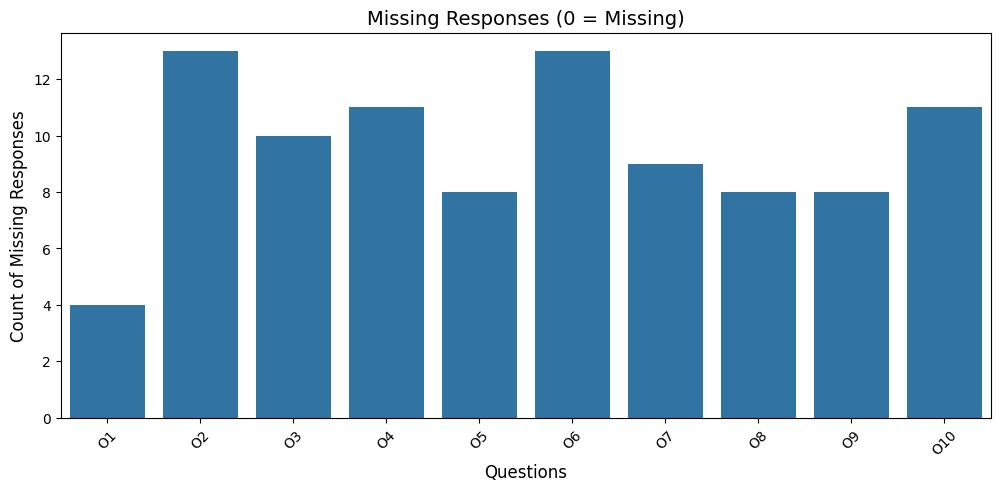

In [385]:
for i in range(0, 50, 10):
    current = bigPersonalitiesZeroCount.iloc[i: i+10]
    plt.figure(figsize=(12,5))
    sns.barplot(x=current.index, y=current.values)
    plt.title("Missing Responses (0 = Missing)", fontsize=14)
    plt.xlabel("Questions", fontsize=12)
    plt.ylabel("Count of Missing Responses", fontsize=12)
    plt.xticks(rotation=45)
    plt.show()

## Completeness Check 

In [386]:
completeness = (df != 0).sum() / (len(df))

completeness_df = pd.DataFrame({
    'BigPersonalities': bigPersonalitiesZeroCount,
    'GritScore': GritScoreZeroCount, 
    'MissingCountries': (df['country'] == 'Unknown').sum(),
    'NonMissingCounts': (df != 0).sum(),
    'CompletenessRate': completeness.round(3)
})

In [387]:
completeness_df[completeness_df['GritScore'].notna()]

,BigPersonalities,GritScore,MissingCountries,NonMissingCounts,CompletenessRate
GS1,NaN,7.0,30,2936,0.998
GS10,NaN,9.0,30,2934,0.997
GS11,NaN,8.0,30,2935,0.997
GS12,NaN,16.0,30,2927,0.995
GS2,NaN,7.0,30,2936,0.998
GS3,NaN,7.0,30,2936,0.998
GS4,NaN,22.0,30,2921,0.993
GS5,NaN,7.0,30,2936,0.998
GS6,NaN,9.0,30,2934,0.997
GS7,NaN,9.0,30,2934,0.997


### Filling in zero values with median values within that column and we are not using mean to avoid outliers

In [388]:
print(int(df['GS1'].median()))

2


In [389]:
for i in GritScoreZeroCount.index:
    value = int(df[i].median())
    df[i] = df[i].replace(0, value)

In [390]:
GritScoreZeroCount = (df[gritColumns] == 0).sum()
print(GritScoreZeroCount)

GS1     0
GS2     0
GS3     0
GS4     0
GS5     0
GS6     0
GS7     0
GS8     0
GS9     0
GS10    0
GS11    0
GS12    0
dtype: int64


In [391]:
for i in bigPersonalitiesZeroCount.index:
    value = int(df[i].median())
    df[i] = df[i].replace(0, value)

In [392]:
bigPersonalitiesZeroCount = (df[bigPersonalities] == 0).sum()
print(bigPersonalitiesZeroCount)

E1     0
E2     0
E3     0
E4     0
E5     0
E6     0
E7     0
E8     0
E9     0
E10    0
N1     0
N2     0
N3     0
N4     0
N5     0
N6     0
N7     0
N8     0
N9     0
N10    0
A1     0
A2     0
A3     0
A4     0
A5     0
A6     0
A7     0
A8     0
A9     0
A10    0
C1     0
C2     0
C3     0
C4     0
C5     0
C6     0
C7     0
C8     0
C9     0
C10    0
O1     0
O2     0
O3     0
O4     0
O5     0
O6     0
O7     0
O8     0
O9     0
O10    0
dtype: int64


In [393]:
print(df["operatingsystem"].value_counts())
print(df["browser"].value_counts())
print(df[["screenw", "screenh"]].describe())
print(df[["introelapse", "testelapse", "surveyelapse"]].describe())

operatingsystem
Windows          1764
Macintosh         448
iOS               387
Linux             264
ChromeOS           61
Unknown            15
Windows Phone       3
Blackberry          1
Name: count, dtype: int64
browser
Chrome                         1552
Safari                          554
Microsoft Internet Explorer     380
Firefox                         334
AndroidBrowser                   42
Opera                            30
Unknown                          27
ChromeiOS                        21
UCBrowser                         2
SeaMonkey                         1
Name: count, dtype: int64
           screenw      screenh
count  2943.000000  2943.000000
mean   1239.548420   841.729867
std     448.427293   175.972309
min       0.000000     0.000000
25%    1024.000000   768.000000
50%    1366.000000   800.000000
75%    1440.000000  1024.000000
max    3440.000000  1920.000000
       introelapse   testelapse  surveyelapse
count  2943.000000  2943.000000   2943.000000
mean    

Since there are missing values in screenw and screenh and the two are unlikely to be strong predictors, I will remove the columns. I will also be removing rows with unreasonable timings.

In [394]:
df = df.drop(columns = ["screenw", "screenh"])

(array([7.300e+01, 1.462e+03, 8.800e+02, 2.830e+02, 1.060e+02, 5.600e+01,
        3.400e+01, 1.700e+01, 9.000e+00, 1.000e+01, 1.000e+00, 5.000e+00,
        2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00]),
 array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
         900., 1000., 1100., 1200., 1300., 1400., 1500., 1600., 1700.,
        1800., 1900., 2000., 2100., 2200., 2300., 2400., 2500., 2600.,
        2700., 2800., 2900., 3000., 3100., 3200., 3300., 3400., 3500.,
        3600., 3700., 3800., 3900., 4000., 4100., 4200., 4300., 4400.,
        4500., 4600.,

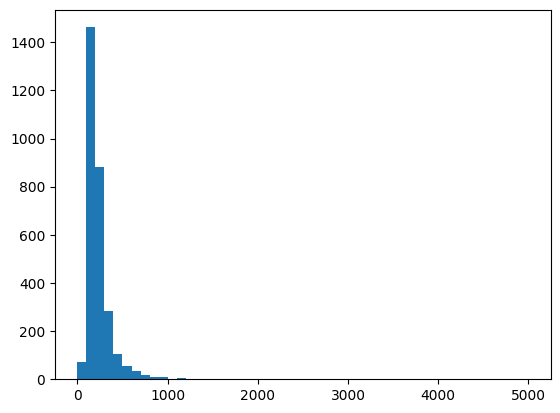

In [395]:
plt.hist(df["surveyelapse"], bins=50, range=(0,5000)) 

(array([1.961e+03, 3.990e+02, 1.810e+02, 1.060e+02, 5.600e+01, 3.800e+01,
        2.200e+01, 2.200e+01, 1.700e+01, 1.800e+01, 1.100e+01, 1.100e+01,
        5.000e+00, 1.000e+01, 1.000e+01, 8.000e+00, 6.000e+00, 2.000e+00,
        4.000e+00, 3.000e+00, 3.000e+00, 3.000e+00, 2.000e+00, 2.000e+00,
        3.000e+00, 4.000e+00, 1.000e+00, 6.000e+00, 2.000e+00, 1.000e+00,
        4.000e+00, 3.000e+00, 4.000e+00, 3.000e+00, 6.000e+00, 2.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00]),
 array([   0.,   20.,   40.,   60.,   80.,  100.,  120.,  140.,  160.,
         180.,  200.,  220.,  240.,  260.,  280.,  300.,  320.,  340.,
         360.,  380.,  400.,  420.,  440.,  460.,  480.,  500.,  520.,
         540.,  560.,  580.,  600.,  620.,  640.,  660.,  680.,  700.,
         720.,  740.,  760.,  780.,  800.,  820.,  840.,  860.,  880.,
         900.,  920.,

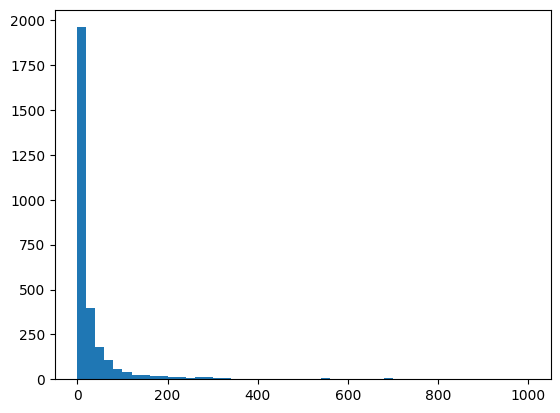

In [396]:
plt.hist(df["introelapse"], bins=50, range=(0,1000)) 

(array([  0.,   1.,  90., 484., 605., 532., 362., 235., 168., 104.,  83.,
         44.,  34.,  38.,  34.,  23.,  18.,  14.,  10.,   9.,   7.,   5.,
          5.,   7.,   2.,   2.,   3.,   0.,   5.,   0.,   1.,   1.,   3.,
          3.,   2.,   1.,   1.,   2.,   1.,   0.,   0.,   1.,   0.,   0.,
          1.,   2.,   0.,   0.,   0.,   0.]),
 array([   0.,   40.,   80.,  120.,  160.,  200.,  240.,  280.,  320.,
         360.,  400.,  440.,  480.,  520.,  560.,  600.,  640.,  680.,
         720.,  760.,  800.,  840.,  880.,  920.,  960., 1000., 1040.,
        1080., 1120., 1160., 1200., 1240., 1280., 1320., 1360., 1400.,
        1440., 1480., 1520., 1560., 1600., 1640., 1680., 1720., 1760.,
        1800., 1840., 1880., 1920., 1960., 2000.]),
 <BarContainer object of 50 artists>)

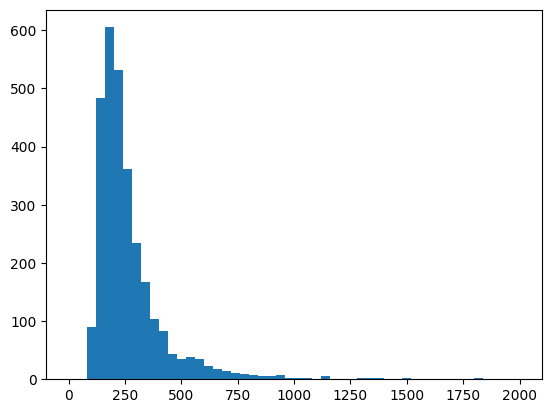

In [397]:
plt.hist(df["testelapse"], bins=50, range=(0,2000)) 

Will decide on the timing thing later with the help of others. Unsure what to do. Lots of unreasonably long times for all three but usure of cutoff. Seems to be some unreasonably short times for testelapes such as 7 seconds for 50 questions. Also unsure of a cutoff for this.

Will reverse the scores of negatively worded survey questions and then create columns for composite personality and grit scores.

In [398]:
reverse_items = ["E2", "E4", "E6", "E8", "E10", "N1", "N3", "N5", "N6", "N7", "N8", "N9", "N10", "A1", "A3", "A5", "A7", "C2", "C4", "C6", "C8", "O2", "O4", "O6", "GS1", "GS4", "GS6", "GS9", "GS10", "GS12"]
df[reverse_items] = 6 - df[reverse_items]

In [399]:
extraversion_items = ["E1","E2","E3","E4","E5","E6","E7","E8","E9","E10"]
neuroticism_items = ["N1","N2","N3","N4","N5","N6","N7","N8","N9","N10"]
agreeableness_items = ["A1","A2","A3","A4","A5","A6","A7","A8","A9","A10"]
conscientious_items = ["C1","C2","C3","C4","C5","C6","C7","C8","C9","C10"]
openness_items = ["O1","O2","O3","O4","O5","O6","O7","O8","O9","O10"]
grit_items = ["GS1", "GS2", "GS3", "GS4", "GS5", "GS6", "GS7", "GS8", "GS9", "GS10", "GS11", "GS12"]

df["Extraversion"] = df[extraversion_items].mean(axis=1)
df["Neuroticism"] = df[neuroticism_items].mean(axis=1)
df["Agreeableness"] = df[agreeableness_items].mean(axis=1)
df["Conscientiousness"] = df[conscientious_items].mean(axis=1)
df["Openness"] = df[openness_items].mean(axis=1)
df["Grit"] = df[grit_items].mean(axis=1)

In [400]:
df.shape

(2943, 99)

Next I will explore the distribution of the grit items

In [401]:
print(df[gritColumns].describe())

               GS1          GS2          GS3          GS4          GS5  \
count  2943.000000  2943.000000  2943.000000  2943.000000  2943.000000   
mean      3.798505     2.464492     2.867142     3.157662     2.744139   
std       0.991725     1.119938     1.231395     1.148824     1.275233   
min       1.000000     1.000000     1.000000     1.000000     1.000000   
25%       3.000000     2.000000     2.000000     2.000000     2.000000   
50%       4.000000     2.000000     3.000000     3.000000     3.000000   
75%       5.000000     3.000000     4.000000     4.000000     4.000000   
max       5.000000     5.000000     5.000000     5.000000     5.000000   

               GS6          GS7          GS8          GS9         GS10  \
count  2943.000000  2943.000000  2943.000000  2943.000000  2943.000000   
mean      4.039755     2.974516     2.903500     3.469589     3.363235   
std       1.049805     1.199236     1.300864     1.130660     1.339245   
min       1.000000     1.000000     1

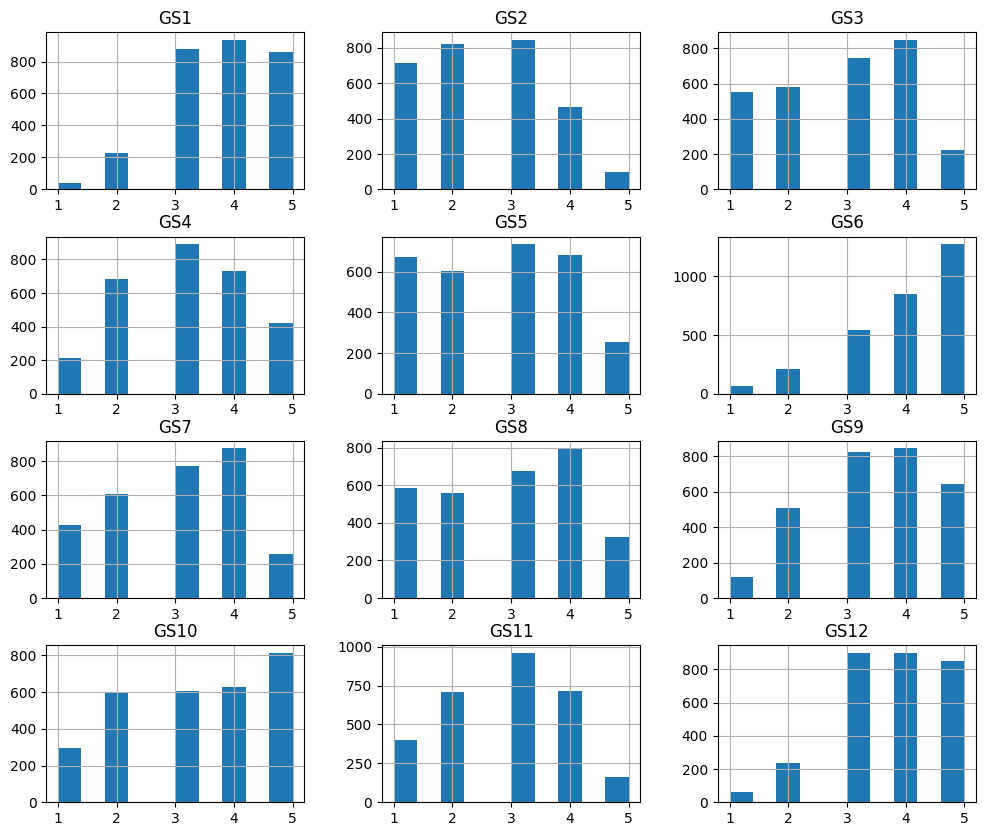

In [402]:
df[gritColumns].hist(figsize=(12,10))
plt.show()

I will now take a look at the distribution of the overall grit score.

count    2943.000000
mean        3.198890
std         0.695226
min         1.083333
25%         2.666667
50%         3.166667
75%         3.750000
max         5.000000
Name: Grit, dtype: float64


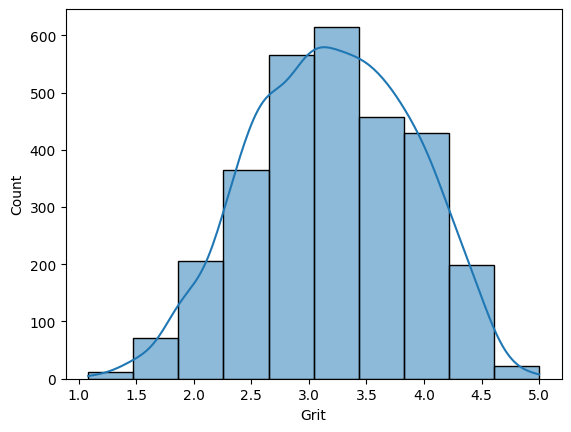

In [403]:
print(df["Grit"].describe())
sns.histplot(df["Grit"], kde=True, bins=10)
plt.show()

The overall grit score seems to follow a normal distribution. There are no floor/ceiling effects.

I will now do the same for the big five personality test.

In [404]:
print(df[bigPersonalities].describe())

                E1           E2           E3           E4           E5  \
count  2943.000000  2943.000000  2943.000000  2943.000000  2943.000000   
mean      2.683316     3.274210     3.328916     2.867822     3.327897   
std       1.255694     1.326367     1.182183     1.205525     1.211291   
min       1.000000     1.000000     1.000000     1.000000     1.000000   
25%       2.000000     2.000000     2.000000     2.000000     2.000000   
50%       3.000000     3.000000     3.000000     3.000000     3.000000   
75%       4.000000     4.000000     4.000000     4.000000     4.000000   
max       5.000000     5.000000     5.000000     5.000000     5.000000   

                E6           E7           E8           E9          E10  ...  \
count  2943.000000  2943.000000  2943.000000  2943.000000  2943.000000  ...   
mean      3.568468     2.769623     2.613660     2.970438     2.368332  ...   
std       1.226818     1.384311     1.257436     1.331574     1.274485  ...   
min       1.00000

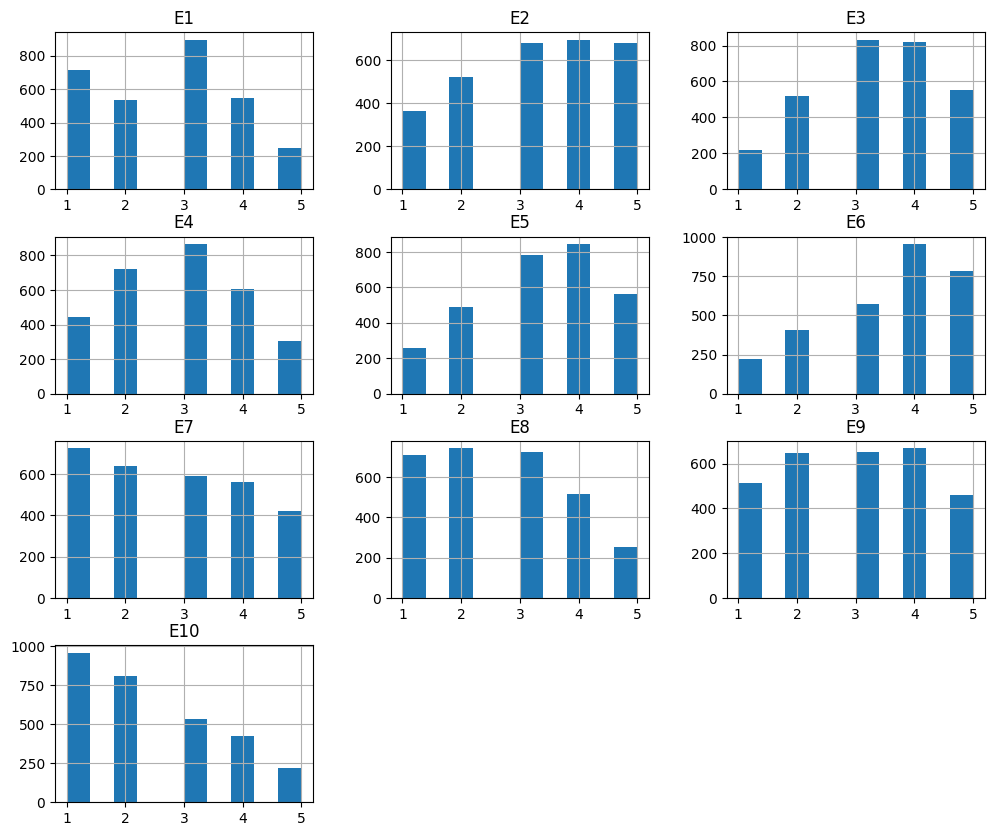

In [405]:
df[extraversion_items].hist(figsize=(12,10))
plt.show()

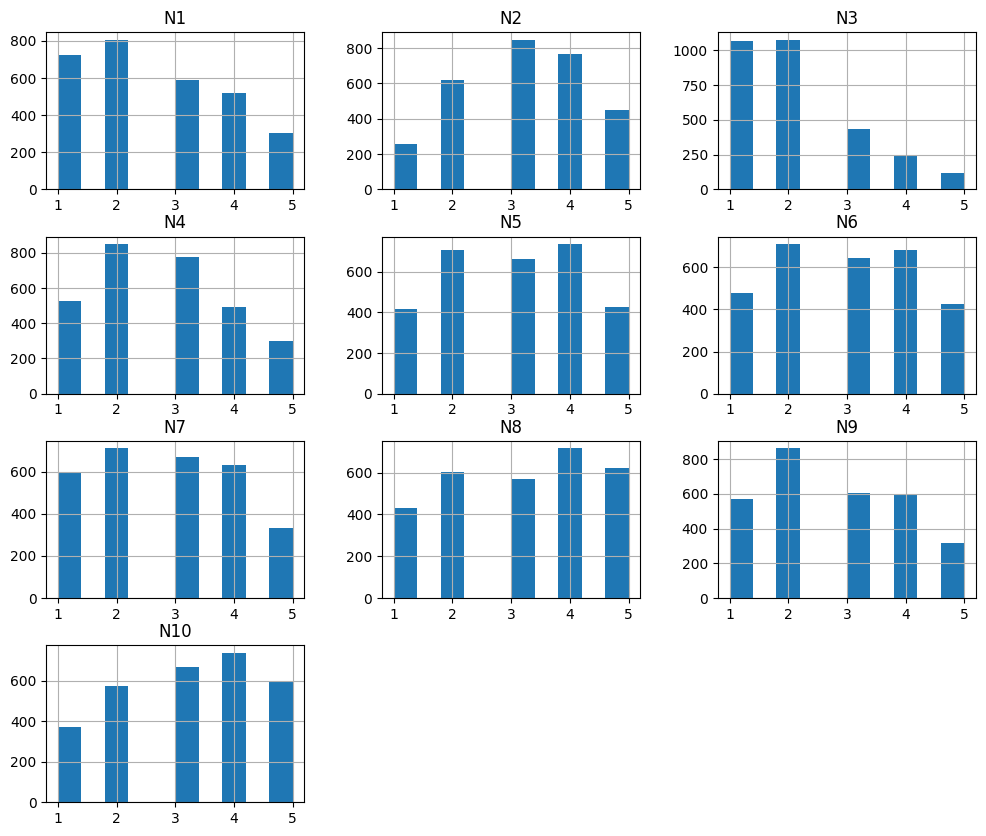

In [406]:
df[neuroticism_items].hist(figsize=(12,10))
plt.show()

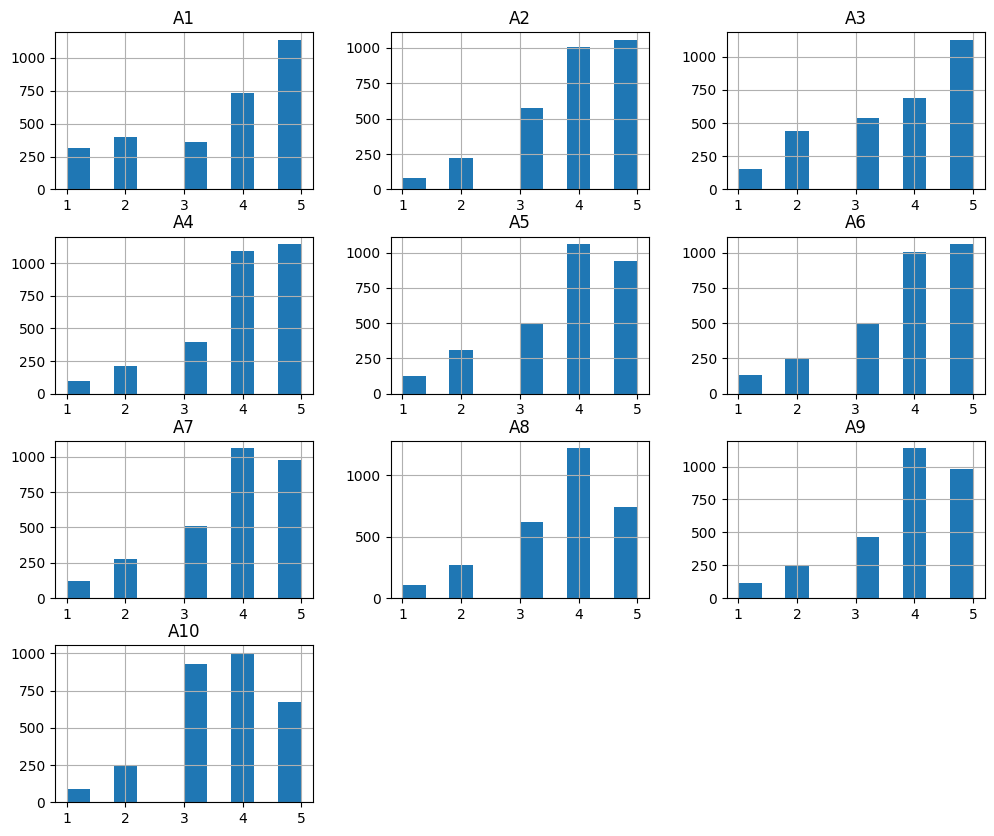

In [407]:
df[agreeableness_items].hist(figsize=(12,10))
plt.show()

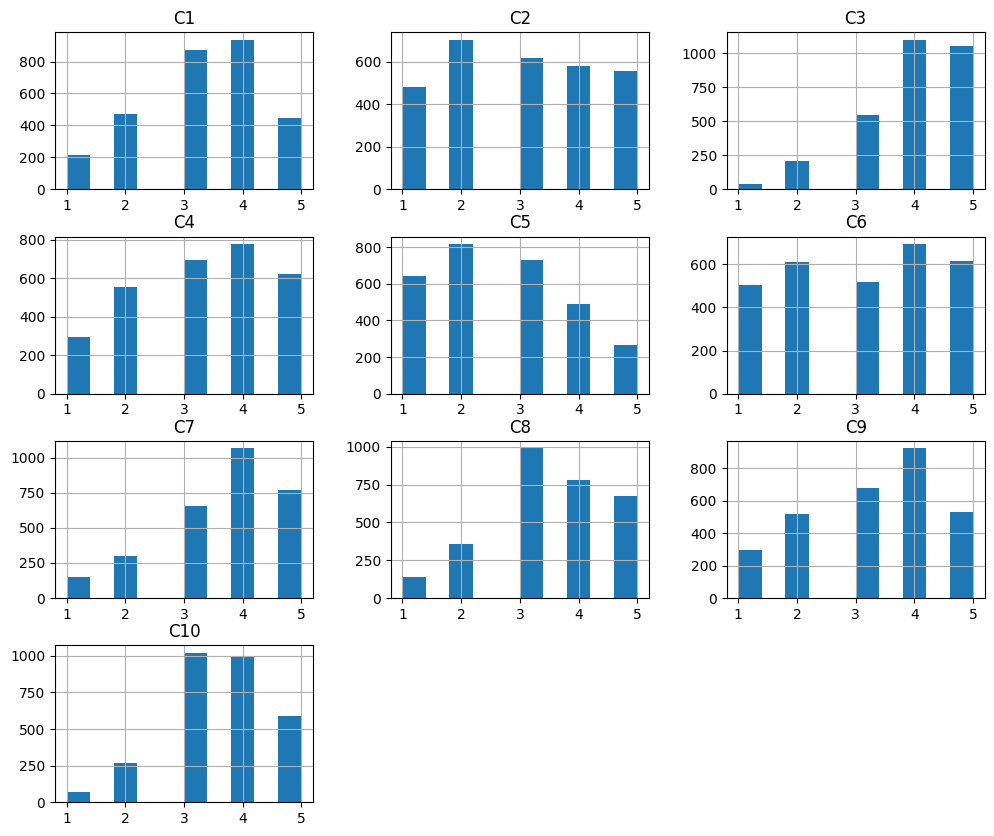

In [408]:
df[conscientious_items].hist(figsize=(12,10))
plt.show()

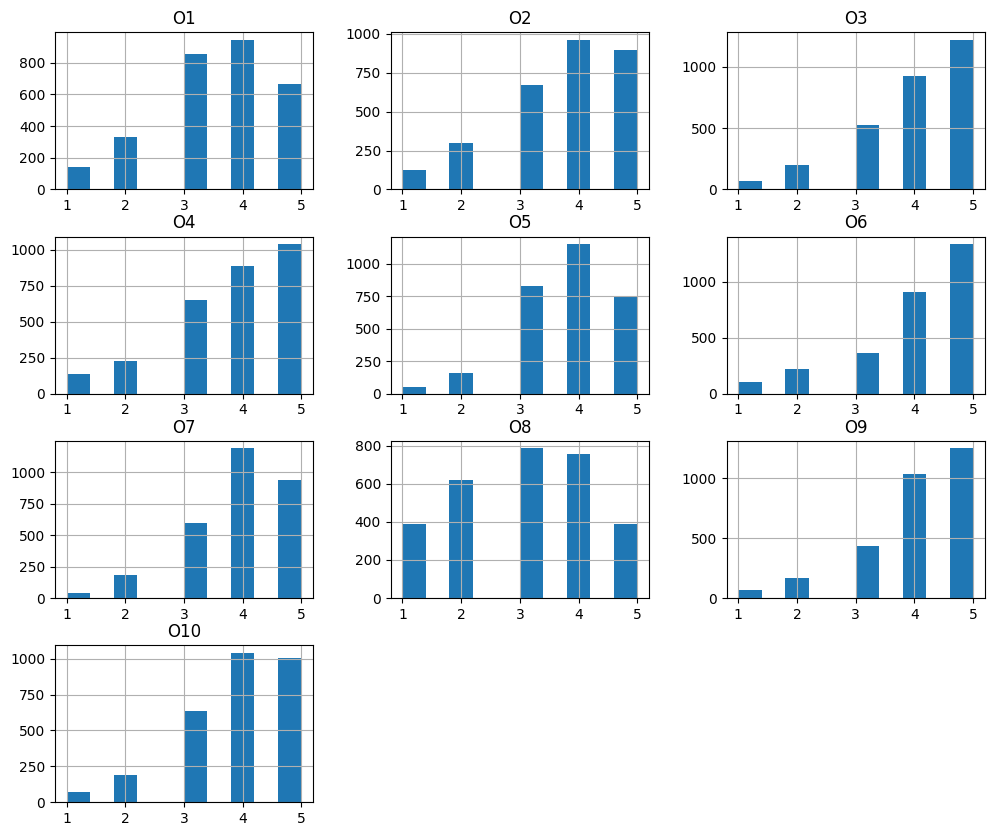

In [409]:
df[openness_items].hist(figsize=(12,10))
plt.show()

In [410]:
bigfive_cols = ["Openness", "Conscientiousness", "Extraversion", "Agreeableness", "Neuroticism"]

correlations = df[["Grit"] + bigfive_cols].corr()
print(correlations["Grit"])

Grit                 1.000000
Openness             0.117762
Conscientiousness    0.635379
Extraversion         0.202755
Agreeableness        0.270287
Neuroticism          0.364806
Name: Grit, dtype: float64


Coscientiousness is highly correlated with grit

In [411]:
#remove rows below age 18
df.drop(df[df['age'] < 18].index, inplace=True)

<Axes: xlabel='age'>

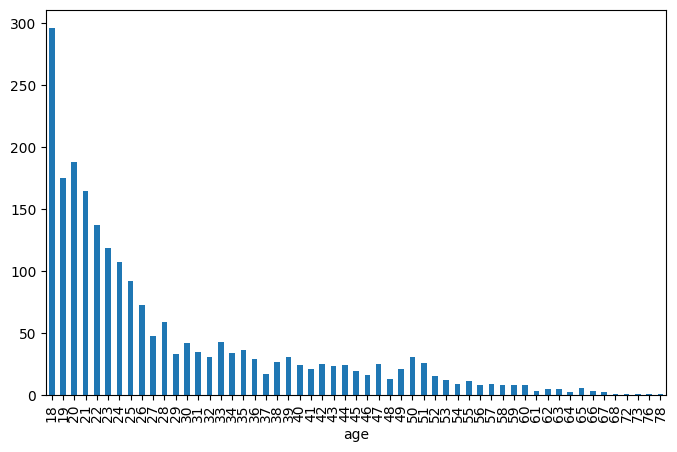

In [412]:
#after dropping 
df['age'].value_counts().sort_index().plot(kind='bar', figsize=(8,5))

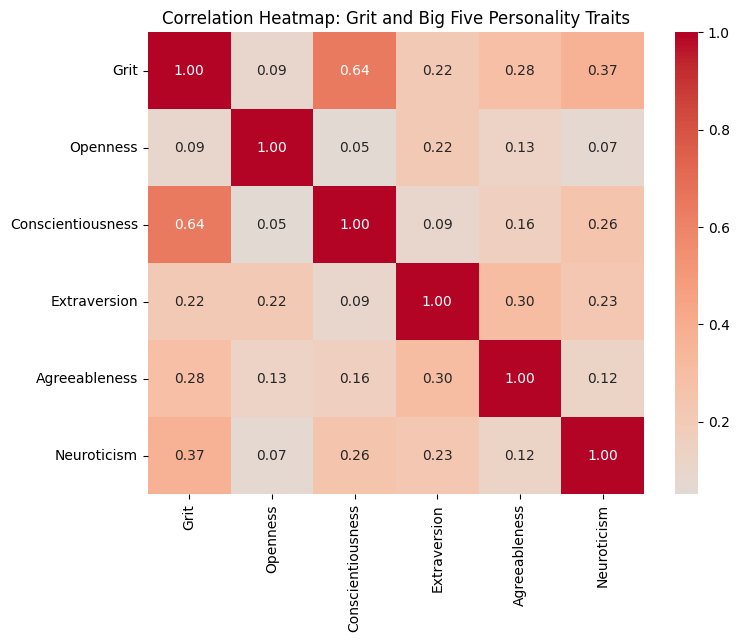

In [436]:
# creating correlation matrix
corr = df[['Grit', 'Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism']].corr()

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Correlation Heatmap: Grit and Big Five Personality Traits')
plt.show()

In [ ]:
# Add new columns age, familysize to the existing list of demographics
demographics.extend(["age", "familysize"])

#creating a demographic df
demographics_df = df[demographics]

# checking for any remaining 0 values in demographics
demographicZeroCount = (demographics_df == 0).sum()
print(demographicZeroCount)


print(demographics_df.head(
))

education      19
urban          25
gender          3
engnat         11
hand            8
religion       28
orientation    55
race           17
voted          16
married         8
age             0
familysize      0
dtype: int64
    education  urban  gender  engnat  hand  religion  orientation  race  \
4           4      2       1       2     1         2            1     1   
6           3      2       1       1     1         3            1     4   
8           3      3       1       2     1        12            1     4   
10          3      1       1       2     1         8            1     1   
11          2      2       2       1     2        12            1     4   

    voted  married  age  familysize  
4       2        2   38           3  
6       2        3   35           1  
8       2        3   50           3  
10      1        3   52           3  
11      1        1   20           1  


In [415]:
#checking unique value in each column
for col in demographics_df.columns:
    print(col, df[col].unique())


education [4 3 2 1 0]
urban [2 3 1 0]
gender [1 2 3 0]
engnat [2 1 0]
hand [1 2 3 0]
religion [ 2  3 12  8  4 10  6  1  9  7  0  5 11]
orientation [1 5 2 4 0 3]
race [1 4 3 2 5 0]
voted [2 1 0]
married [2 3 1 0]
age [38 35 50 52 20 23 27 18 24 26 25 44 19 21 30 36 47 22 43 40 62 34 31 48
 33 42 39 32 37 45 58 57 49 51 55 46 53 65 72 63 28 60 29 67 54 64 59 41
 56 73 61 78 76 66 68]
familysize [ 3  1  9  2  4  6  7  5 17  8 10 11 12 13]


In [417]:
#how are we handling the zeroes in demographics
#since some are categorical, we are subistuting the 0 with Nan, we can change it back if needed
#shoudl i change all variable back to categroical for better aanslyis?

# Replace 0s with NaN in all demographic columns

for col in demographics:
    if 0 in df[col].unique():
        df[col] = df[col].replace(0, np.nan)

print(df[demographics].head)


<bound method NDFrame.head of       education  urban  gender  engnat  hand  religion  orientation  race  \
4           4.0    2.0     1.0     2.0   1.0       2.0          1.0   1.0   
6           3.0    2.0     1.0     1.0   1.0       3.0          1.0   4.0   
8           3.0    3.0     1.0     2.0   1.0      12.0          1.0   4.0   
10          3.0    1.0     1.0     2.0   1.0       8.0          1.0   1.0   
11          2.0    2.0     2.0     1.0   2.0      12.0          1.0   4.0   
...         ...    ...     ...     ...   ...       ...          ...   ...   
4260        4.0    3.0     1.0     1.0   1.0      12.0          1.0   4.0   
4263        2.0    3.0     2.0     2.0   1.0       2.0          1.0   4.0   
4265        2.0    1.0     2.0     1.0   1.0       1.0          1.0   4.0   
4266        3.0    2.0     1.0     1.0   1.0       1.0          1.0   4.0   
4269        2.0    3.0     1.0     1.0   1.0       2.0          1.0   4.0   

      voted  married  age  familysize  
4    

In [418]:
# Identify categorical columns
categorical_cols = ['gender', 'education', 'urban', 'religion', 'race', 
                    'married', 'engnat', 'hand', 'orientation', 'voted' ]

# Convert to category dtype
for col in demographics_df:
    df[col] = df[col].astype('category')

# Optional: check how they look
for col in categorical_cols:
    print(f"\n{col} categories:", df[col].unique())


gender categories: [1.0, 2.0, 3.0, NaN]
Categories (3, float64): [1.0, 2.0, 3.0]

education categories: [4.0, 3.0, 2.0, 1.0, NaN]
Categories (4, float64): [1.0, 2.0, 3.0, 4.0]

urban categories: [2.0, 3.0, 1.0, NaN]
Categories (3, float64): [1.0, 2.0, 3.0]

religion categories: [2.0, 3.0, 12.0, 8.0, 4.0, ..., 9.0, 7.0, NaN, 5.0, 11.0]
Length: 13
Categories (12, float64): [1.0, 2.0, 3.0, 4.0, ..., 9.0, 10.0, 11.0, 12.0]

race categories: [1.0, 4.0, 3.0, 2.0, 5.0, NaN]
Categories (5, float64): [1.0, 2.0, 3.0, 4.0, 5.0]

married categories: [2.0, 3.0, 1.0, NaN]
Categories (3, float64): [1.0, 2.0, 3.0]

engnat categories: [2.0, 1.0, NaN]
Categories (2, float64): [1.0, 2.0]

hand categories: [1.0, 2.0, 3.0, NaN]
Categories (3, float64): [1.0, 2.0, 3.0]

orientation categories: [1.0, 5.0, 2.0, 4.0, NaN, 3.0]
Categories (5, float64): [1.0, 2.0, 3.0, 4.0, 5.0]

voted categories: [2.0, 1.0, NaN]
Categories (2, float64): [1.0, 2.0]


In [419]:
df[categorical_cols].isna().sum()


gender          3
education      19
urban          25
religion       28
race           17
married         8
engnat         11
hand            8
orientation    55
voted          16
dtype: int64

In [420]:

# Define mapping dictionaries
education_map = {1: 'Less than high school', 2: 'High school', 3: 'University', 4: 'Graduate'}
urban_map = {1: 'Rural', 2: 'Suburban', 3: 'Urban'}
gender_map = {1: 'Male', 2: 'Female', 3: 'Other'}
engnat_map = {1: 'Yes', 2: 'No'}
hand_map = {1: 'Right', 2: 'Left', 3: 'Both'}
religion_map = {
    1: 'Agnostic', 2: 'Atheist', 3: 'Buddhist', 4: 'Christian (Catholic)',
    5: 'Christian (Mormon)', 6: 'Christian (Protestant)', 7: 'Christian (Other)',
    8: 'Hindu', 9: 'Jewish', 10: 'Muslim', 11: 'Sikh', 12: 'Other'
}
orientation_map = {1: 'Heterosexual', 2: 'Bisexual', 3: 'Homosexual', 4: 'Asexual', 5: 'Other'}
race_map = {1: 'Asian', 2: 'Arab', 3: 'Black', 4: 'Indigenous/Native/White', 5: 'Other'}
voted_map = {1: 'Yes', 2: 'No'}
married_map = {1: 'Never married', 2: 'Currently married', 3: 'Previously married'}

# --- Apply mappings and explicitly set ordered categories ---

df['education'] = pd.Categorical(
    df['education'].map(education_map),
    categories=['Less than high school', 'High school', 'University', 'Graduate'],
    ordered=True
)

df['urban'] = pd.Categorical(
    df['urban'].map(urban_map),
    categories=['Rural', 'Suburban', 'Urban'],
    ordered=True
)

df['married'] = pd.Categorical(
    df['married'].map(married_map),
    categories=['Never married', 'Currently married', 'Previously married'],
    ordered=True
)

# Unordered categoricals (nominal variables)
df['gender'] = pd.Categorical(df['gender'].map(gender_map))
df['engnat'] = pd.Categorical(df['engnat'].map(engnat_map))
df['hand'] = pd.Categorical(df['hand'].map(hand_map))
df['religion'] = pd.Categorical(df['religion'].map(religion_map))
df['orientation'] = pd.Categorical(df['orientation'].map(orientation_map))
df['race'] = pd.Categorical(df['race'].map(race_map))
df['voted'] = pd.Categorical(df['voted'].map(voted_map))

# Keep numeric columns as numeric
df['age'] = pd.to_numeric(df['age'], errors='coerce')
df['familysize'] = pd.to_numeric(df['familysize'], errors='coerce')


In [421]:
#ordering the categories


In [ ]:
# Summary statistics specifically for age
print(df['age'].describe())

# Value counts for each categorical column
for col in categorical_cols:
    print(f"\n{col.upper()} distribution:")
    print(df[col].value_counts(dropna=False))

#check for familysize similarly

count    2204.000000
mean       28.357532
std        11.397579
min        18.000000
25%        20.000000
50%        24.000000
75%        34.000000
max        78.000000
Name: age, dtype: float64

GENDER distribution:
gender
Female    1391
Male       802
Other        8
NaN          3
Name: count, dtype: int64

EDUCATION distribution:
education
High school              944
University               792
Graduate                 386
Less than high school     63
NaN                       19
Name: count, dtype: int64

URBAN distribution:
urban
Urban       1040
Suburban     700
Rural        439
NaN           25
Name: count, dtype: int64

RELIGION distribution:
religion
Christian (Catholic)      378
Christian (Other)         341
Atheist                   335
Agnostic                  332
Christian (Protestant)    228
Other                     197
Muslim                    139
Hindu                     112
Buddhist                   60
NaN                        28
Christian (Mormon)         23
J

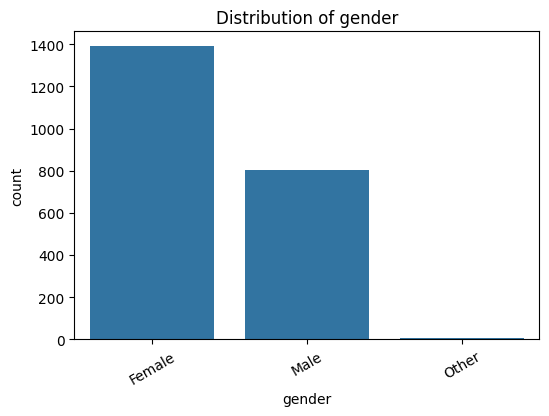

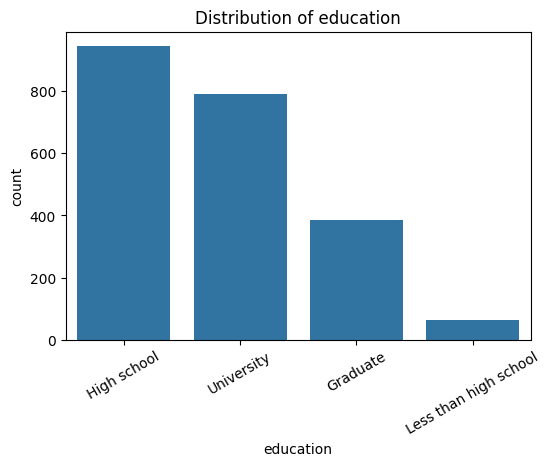

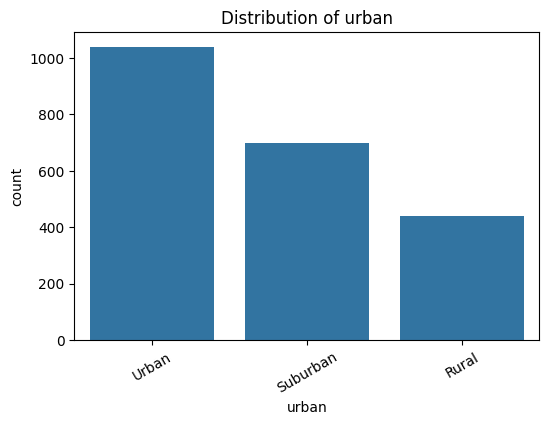

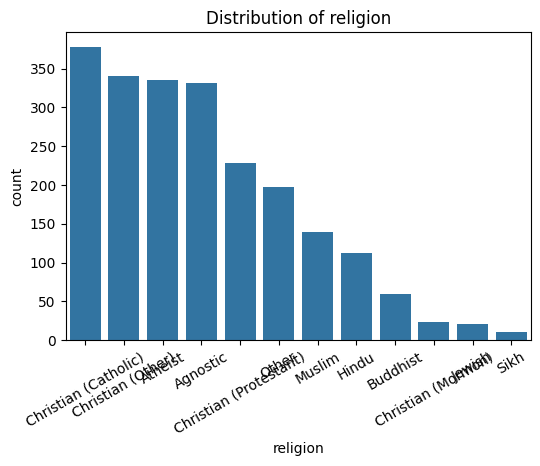

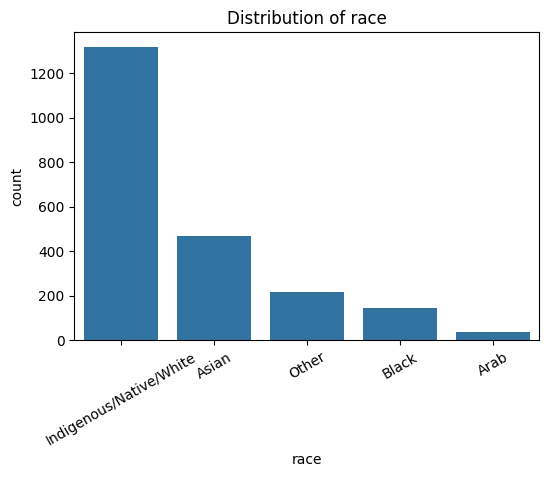

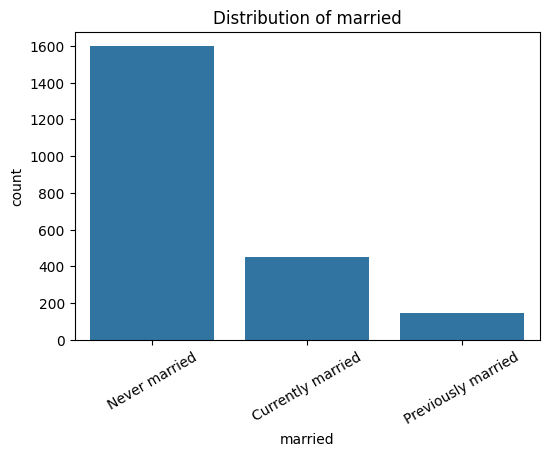

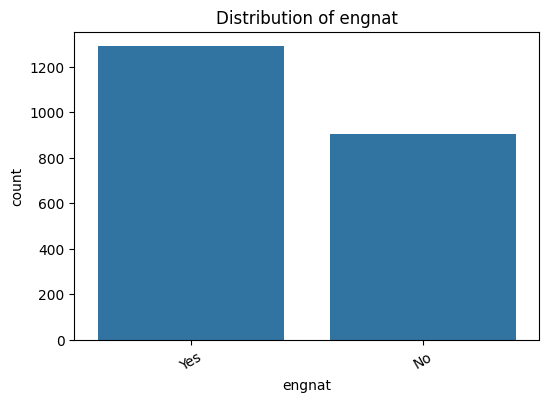

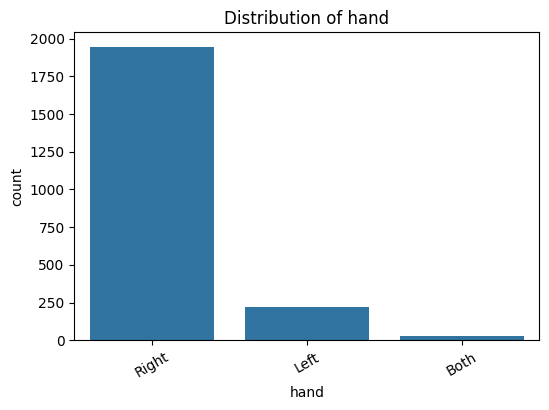

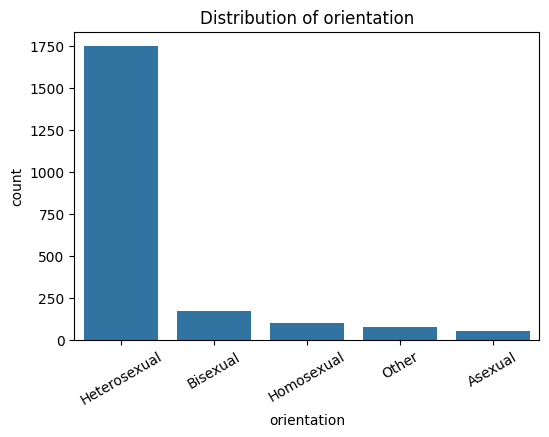

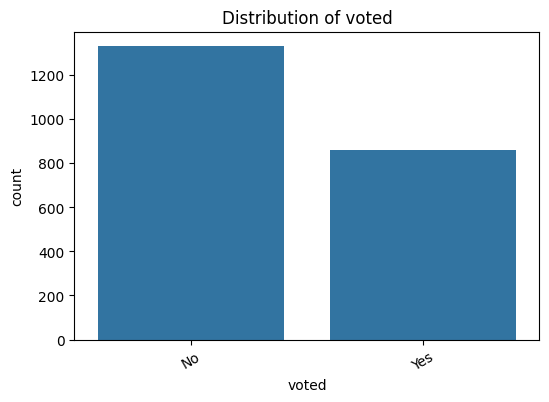

In [423]:
#graphs indicating demographic distribution per column

for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=30)
    plt.show()


In [424]:
df[categorical_cols].isna().sum()


gender          3
education      19
urban          25
religion       28
race           17
married         8
engnat         11
hand            8
orientation    55
voted          16
dtype: int64

In [426]:
#checking what columns are categorized
for col in df.select_dtypes(['category']).columns:
    print(f"{col}: ordered = {df[col].cat.ordered}")


education: ordered = True
urban: ordered = True
gender: ordered = False
engnat: ordered = False
hand: ordered = False
religion: ordered = False
orientation: ordered = False
race: ordered = False
voted: ordered = False
married: ordered = True


In [ ]:
#checking order in columns
for col in df.select_dtypes(include='category').columns:
    cat = df[col].dtype
    print(f"{col}: ordered={cat.ordered}, categories={df[col].cat.categories.tolist()[:5]}")


education: ordered=True, categories=['Less than high school', 'High school', 'University', 'Graduate']
urban: ordered=True, categories=['Rural', 'Suburban', 'Urban']
gender: ordered=False, categories=['Male', 'Female', 'Other']
engnat: ordered=False, categories=['Yes', 'No']
hand: ordered=False, categories=['Right', 'Left', 'Both']
religion: ordered=False, categories=['Agnostic', 'Atheist', 'Buddhist', 'Christian (Catholic)', 'Christian (Mormon)']
orientation: ordered=False, categories=['Heterosexual', 'Bisexual', 'Homosexual', 'Asexual', 'Other']
race: ordered=False, categories=['Asian', 'Arab', 'Black', 'Indigenous/Native/White', 'Other']
voted: ordered=False, categories=['Yes', 'No']
married: ordered=True, categories=['Never married', 'Currently married', 'Previously married']


# Step 3A: Correlation between grit and demographics

Correlation between grit and age: 0.23


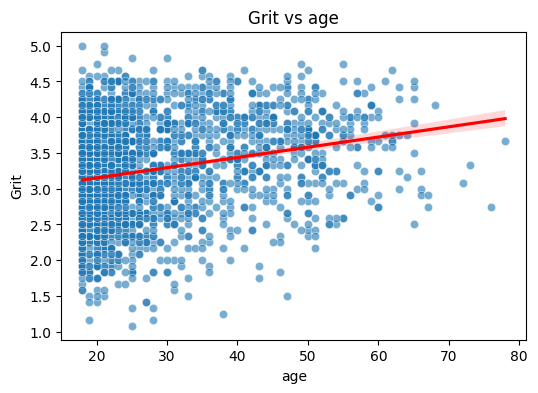

Correlation between grit and familysize: 0.09


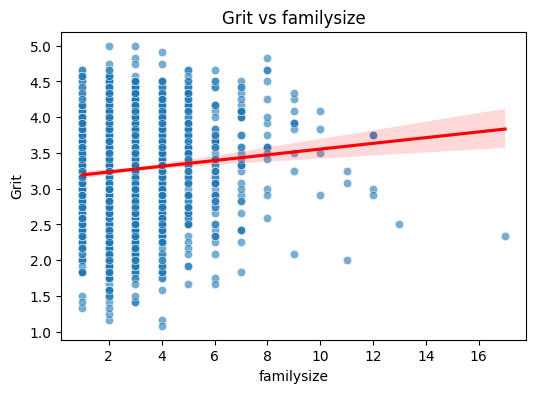

In [428]:
# Step 3A: Correlation between grit and numeric demographics
numeric_cols = ['age', 'familysize']

for col in numeric_cols:
    corr = df['Grit'].corr(df[col])
    print(f"Correlation between grit and {col}: {corr:.2f}")

    plt.figure(figsize=(6,4))
    sns.scatterplot(x=col, y='Grit', data=df, alpha=0.6)
    sns.regplot(x=col, y='Grit', data=df, scatter=False, color='red')
    plt.title(f"Grit vs {col}")
    plt.show()


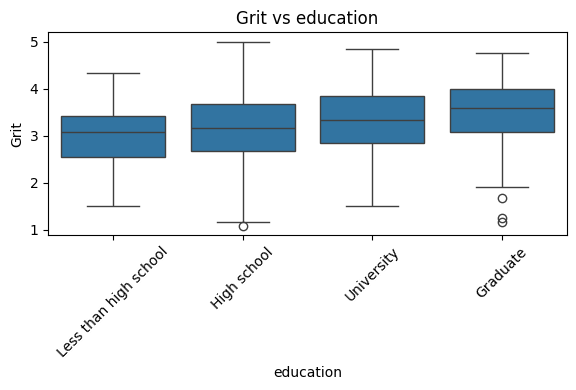

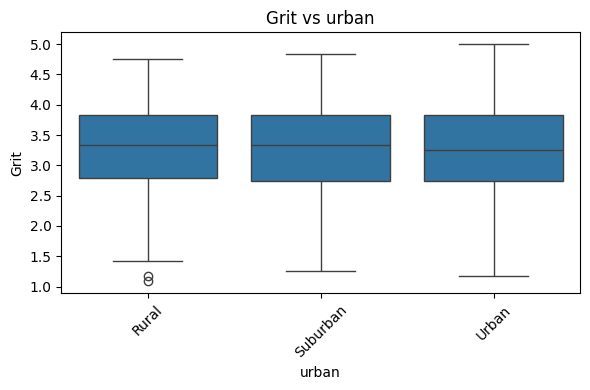

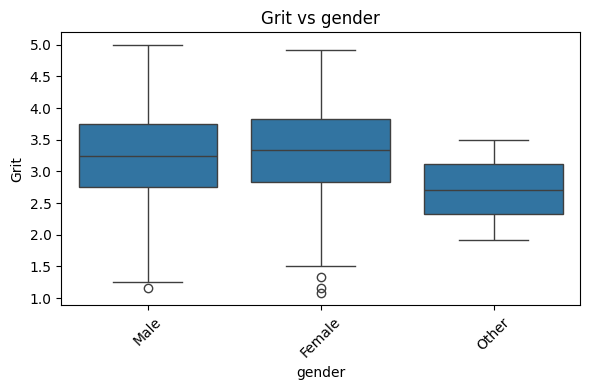

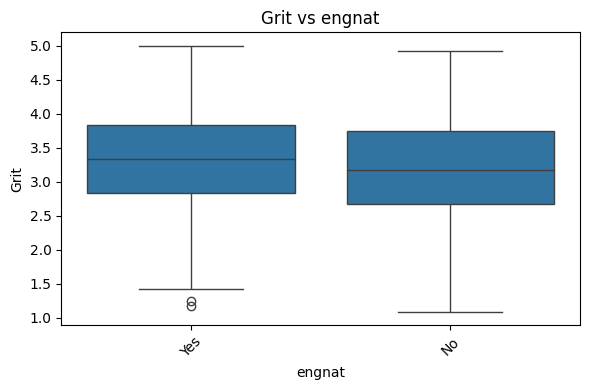

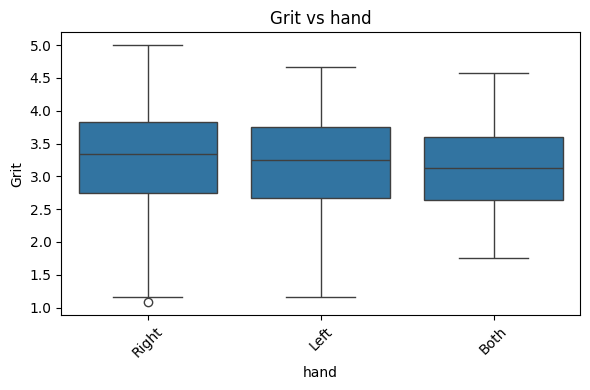

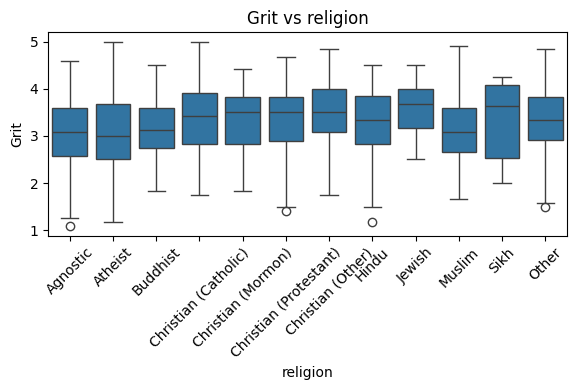

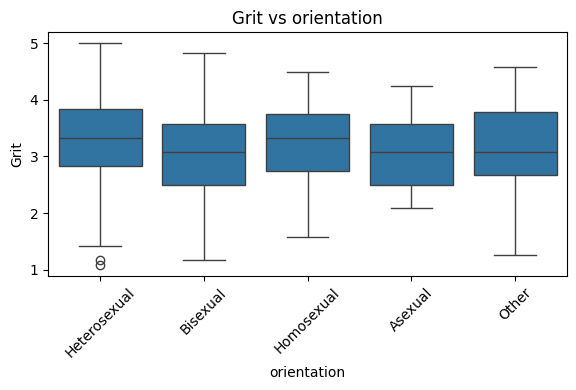

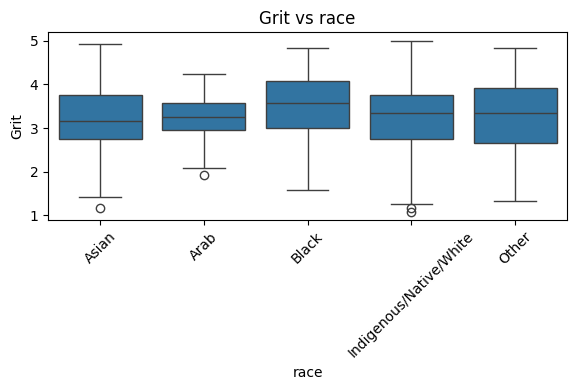

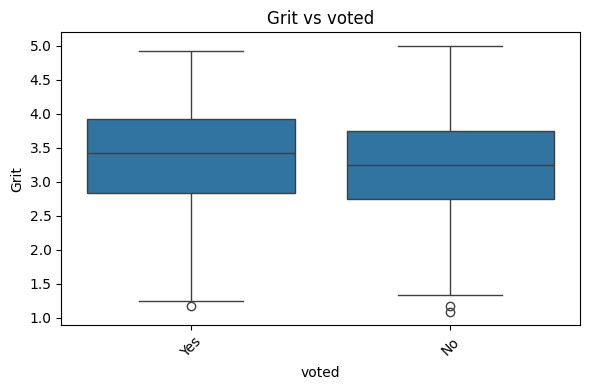

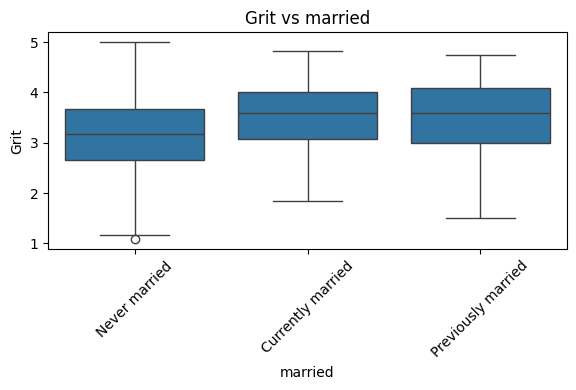

In [429]:
# 2️⃣ Boxplots for categorical variables
categorical_vars = ['education', 'urban', 'gender', 'engnat', 'hand',
                    'religion', 'orientation', 'race', 'voted', 'married']

for col in categorical_vars:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=col, y='Grit', data=df)
    plt.title(f'Grit vs {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Compare Grit Across Groups using p-value, either t-independent test, or one way anova test. 

#key to read it 
t-test	2 groups (e.g., Male vs Female)	p < 0.05 → Significant difference in average Grit
ANOVA	3+ groups (e.g., Education levels)	p < 0.05 → At least one group differs in average Grit

In [432]:
from scipy import stats

categorical_vars = ['education', 'urban', 'gender', 'engnat', 'hand',
                    'religion', 'orientation', 'race', 'voted', 'married']

def compare_grit_by_group(df, col):
    groups = df[col].dropna().unique()

    if len(groups) < 2:
        print(f"{col}: Not enough groups to test\n")
        return

    # If exactly 2 groups -> Independent t-test
    if len(groups) == 2:
        g1 = df[df[col] == groups[0]]['Grit'].dropna()
        g2 = df[df[col] == groups[1]]['Grit'].dropna()
        t, p = stats.ttest_ind(g1, g2, equal_var=False)
        print(f"{col}: t-test between {groups[0]} & {groups[1]} → p = {p:.4f}")

    # If 3 or more groups -> One-way ANOVA
    else:
        samples = [df[df[col] == g]['Grit'].dropna() for g in groups]
        f, p = stats.f_oneway(*samples)
        print(f"{col}: ANOVA across {len(groups)} groups → p = {p:.4f}")


    #running for each variable.
for col in categorical_vars:
        compare_grit_by_group(df, col)



education: ANOVA across 4 groups → p = 0.0000
urban: ANOVA across 3 groups → p = 0.4687
gender: ANOVA across 3 groups → p = 0.0040
engnat: t-test between No & Yes → p = 0.0001
hand: ANOVA across 3 groups → p = 0.0827
religion: ANOVA across 12 groups → p = 0.0000
orientation: ANOVA across 5 groups → p = 0.0001
race: ANOVA across 5 groups → p = 0.0003
voted: t-test between No & Yes → p = 0.0000
married: ANOVA across 3 groups → p = 0.0000


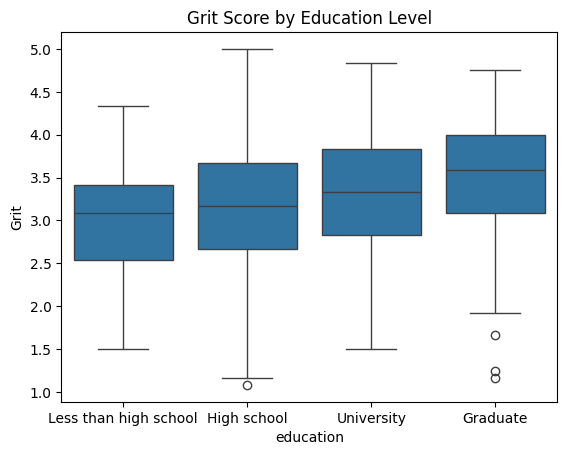

In [ ]:
#visualize above results
sns.boxplot(x='education', y='Grit', data=df)
plt.title('Grit Score by Education Level')
plt.show()

Pros: Quick, clear, and gives exact p-values for significance.

Cons:

It doesn’t show which specific groups differ (only that some do).

It doesn’t adjust for multiple comparisons (risk of false positives).

It only uses classical tests (no visual summaries) #should we use other methods to better clarify?

Identifing Demographic Biases